In [13]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import shapereader
import os
import numpy as np
from PIL import Image
from scipy.interpolate import griddata
import cartopy.io.img_tiles as tile
from cartopy.io import shapereader
import glob
from scipy.interpolate import griddata
import cmocean
import h5py
import netCDF4
import pandas as pd
from scipy import interpolate

In [2]:
df=pd.read_excel('RPL_Data_for_AKORN_Fiber.xls',skiprows=11,header=None)[:56]

In [3]:
latitude=np.array(df[1])[::-1]
lat=[43.9942832]
for l in latitude:
    lat.append(int(l[0:2])+float(l[4:11])/60)
    
longitude=np.array(df[2])[::-1]
lon=[124.1143758]
for l in longitude:
    lon.append(int(l[0:3])+float(l[5:12])/60)

cum_length=np.array([0]+list(6.3-(np.array(df[4])[::-1]-np.array(df[4])[::-1][0])))


In [4]:
interp_cum_length=np.arange(0,0.02*4000,0.02)

f_lon=interpolate.interp1d(cum_length,lon)
lon_interpolate=f_lon(interp_cum_length)

f_lat=interpolate.interp1d(cum_length,lat)
lat_interpolate=f_lat(interp_cum_length)

In [5]:
name_save = 'Interp_bathy_NetCDF_Final.h5'

with h5py.File(name_save, 'r') as f:

    bathy = f.get('bathy')[:] # bathymetry at each channel (in m)
    IU_dist = f.get('IU_dist')[:]  # in meters
    Channel =  f.get('Channel')[:]  # Channel number
    lat  = f.get('lat_inter')[:]  # latitude of each channel
    lon = f.get('lon_inter')[:]# longitude of each channel
    inter_sta_dist = f.get('inter_sta_dist')[:] # distance between each interpolated channel (in m)

In [6]:
f=netCDF4.Dataset('central_oregon_13_navd88_2015.nc')

In [7]:
region_lon=f.variables['lon']
region_lat=f.variables['lat']
topo=f.variables['Band1']

region_lat=region_lat[:5400]
region_lon=region_lon[:6400]
topo=topo[:5400,:6400].astype('int16')

In [8]:
bathy=netCDF4.Dataset('gebco_2023_n44.1_s43.8_w-125.0_e-124.6.nc')
a=bathy.variables['lat']
b=bathy.variables['lon']
c=bathy.variables['elevation']
region_lon_west=np.linspace(-125,-124.6,4000)

func_int = interpolate.interp2d(b,a,c, kind='linear')
cnew=func_int(region_lon_west, region_lat)
newtopo=np.hstack((cnew,topo)).astype('int16')
new_region_lon=np.concatenate((region_lon_west,region_lon))

/tmp/ipykernel_3798556/3386072585.py:7: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  func_int = interpolate.interp2d(b,a,c, kind='linear')
/tmp/ipykernel_3798556/3386072585.py:8: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

        In new code, fo

/home/yaolinm/.local/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1604: UserWarning: The following kwargs were not used by contour: 'latlon'
  result = super().contour(*args, **kwargs)


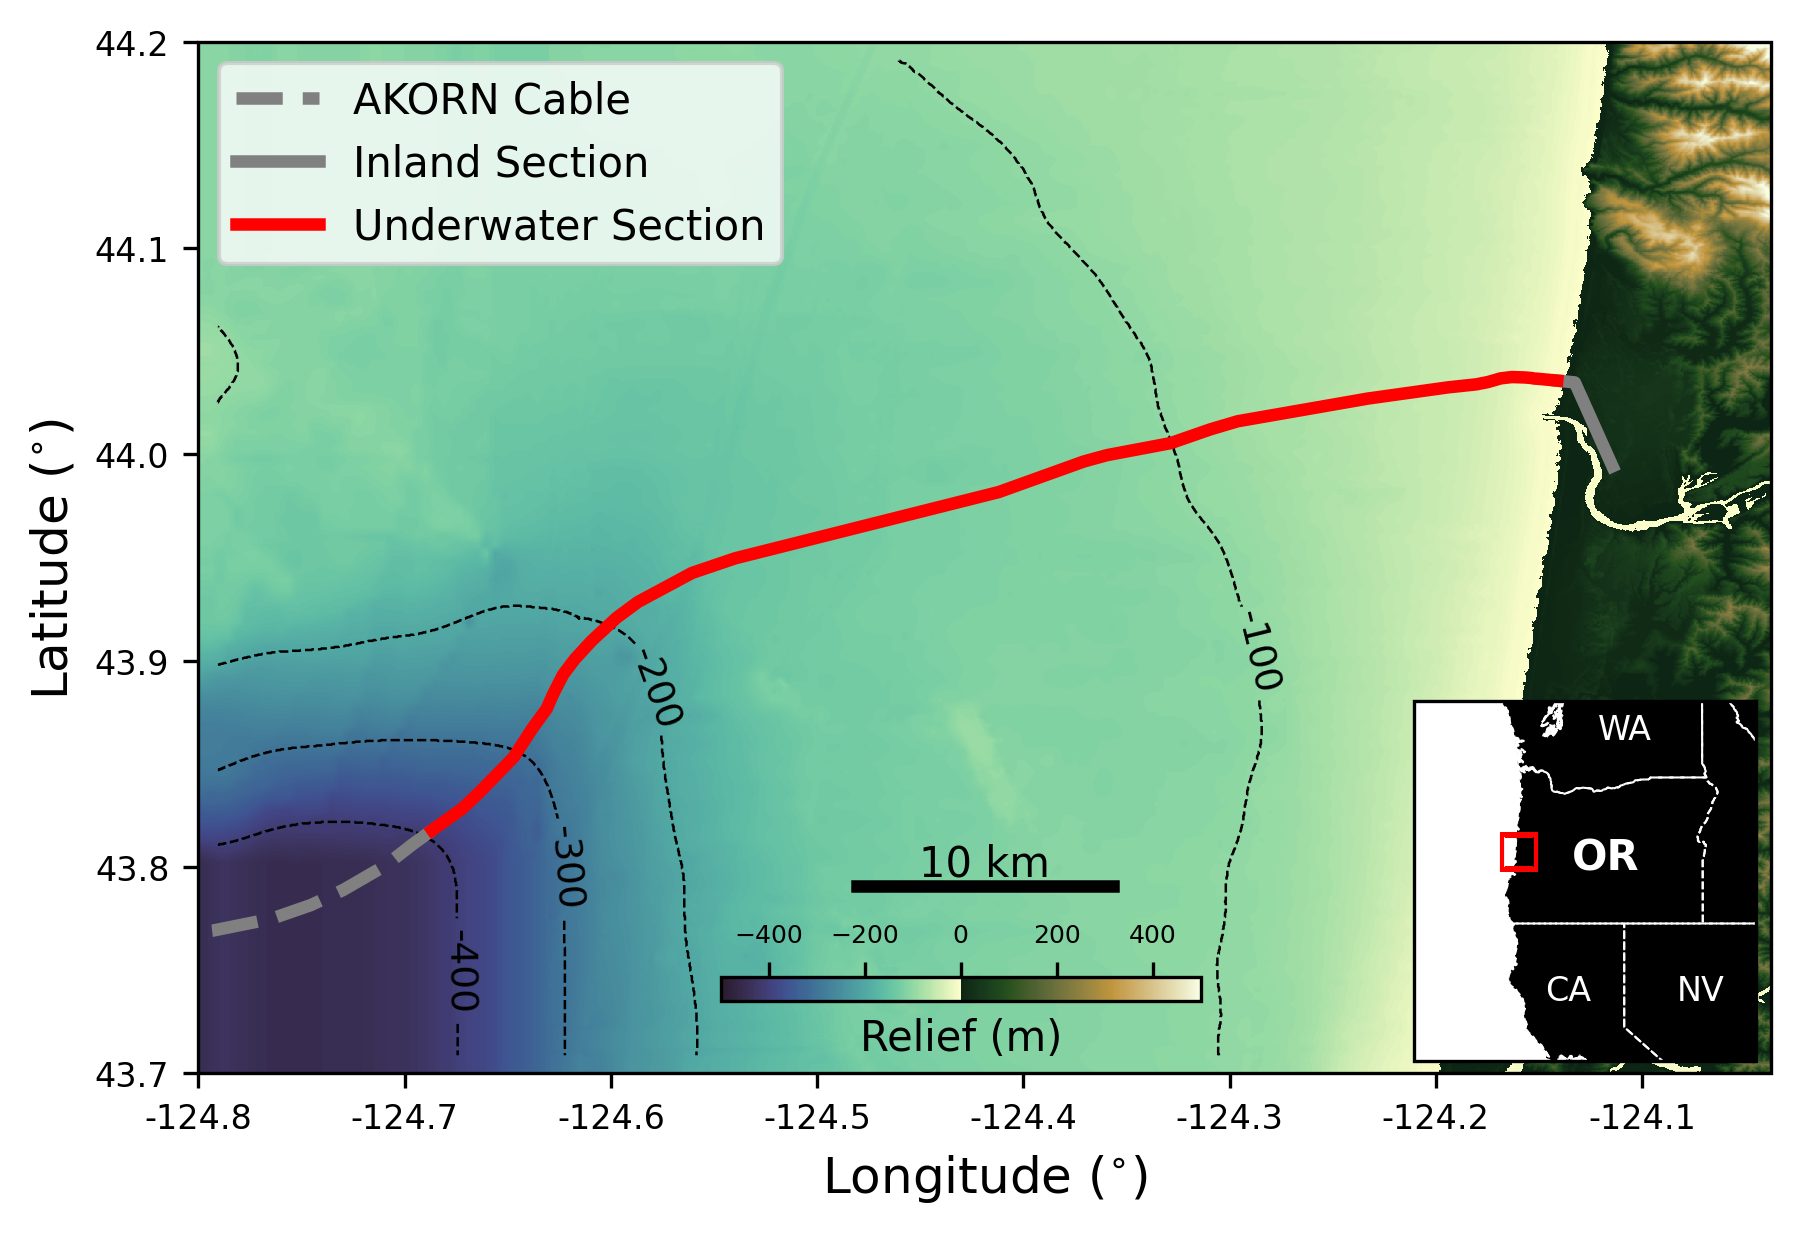

In [12]:
cmap=cmocean.cm.topo

fig = plt.figure(figsize=(8,4),constrained_layout=True)
fig.dpi=300
xlin=new_region_lon[2000:]
xlin[0]=-124.8
ylin=region_lat

ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax.set_xlim((xlin[0],xlin[-1]))
ax.set_ylim((ylin[0],ylin[-1]))

xlocs=[-124.8,-124.7,-124.6,-124.5,-124.4,-124.3,-124.2,-124.1]
ylocs=[44.2,44.1,44.0,43.9,43.8,43.7]
ax.set_xticks(xlocs)
ax.set_yticks(ylocs)
ax.set_xticklabels(labels=["%.1f" % x for x in xlocs], fontsize=8)
ax.set_yticklabels(labels=["%.1f" % y for y in ylocs], fontsize=8)
ax.set_xlabel("Longitude ($^{\circ}$)", fontsize=12)
ax.set_ylabel("Latitude ($^{\circ}$)", fontsize=12)

norm = mcolors.TwoSlopeNorm(vcenter=0,vmin=-500,vmax=500)
pc=ax.pcolormesh(xlin[::4],ylin[::4],newtopo[::4,2000::4],cmap=cmap,norm=norm,zorder=0)

sigma=30
bathy_levels =[-400,-300,-200,-100]
Ct = ax.contour(gaussian_filter(xlin[::4],sigma),gaussian_filter(ylin[::4],sigma)
,gaussian_filter(newtopo[::4,2000::4],sigma),bathy_levels,colors='black',latlon=True,
linewidths=0.6,linestyles='--')

# ax.clabel(Ct, levels=[-400,-300,-200,-100], inline=True, fontsize=10)

manual_locations = [(-124.68,43.75),(-124.62,43.8),(-124.55,43.9),(-124.3,43.9)] 
clbls = ax.clabel(Ct,fmt='%i', fontsize=9,manual=manual_locations, colors="black")

ax.plot(-lon_interpolate[3000:],lat_interpolate[3000:],'grey',zorder=3,linewidth=3,ls='--',label='AKORN Cable')
ax.plot(-lon_interpolate[:350],lat_interpolate[:350],'grey',zorder=3,linewidth=3,label='Inland Section')
ax.plot(-lon_interpolate[350:3000],lat_interpolate[350:3000],'r',zorder=3,linewidth=3,label='Underwater Section')

c2=fig.add_axes([0.39,0.18,0.2,0.02])
cbar=fig.colorbar(pc, cax=c2,orientation='horizontal')
cbar.ax.tick_params(labelsize=6)
cbar.ax.xaxis.set_ticks_position("top")
cbar.set_label('Relief (m)',rotation=0,fontsize=10)

legend = ax.legend(loc='upper left', fontsize=10)
legend.get_frame().set_facecolor('white')
scale_bar(ax,location=(0.5, 0.18),length=10)

left, bottom, width, height =0.6,0.13,0.3,0.3
ax2 = fig.add_axes([left, bottom, width, height],projection=ccrs.Mercator())
ax2.set_yticks([])
ax2.set_xticks([])
ax2.set_extent([-115,-128,38,48],ccrs.Geodetic())
# ax2.add_feature(cfeature.COASTLINE.with_scale('10m'),edgecolor='black')
ax2.add_feature(cfeature.LAND.with_scale('10m'),facecolor='black')
ax2.add_feature(cfeature.OCEAN.with_scale('10m'),facecolor='white')
ax2.add_feature(cfeature.STATES,edgecolor='white',linestyle='--',linewidth=0.5)
# ax2.background_patch.set_visible(True)
# ax2.outline_patch.set_visible(True)
ax2.text(-122,43.5,'OR',c='white',fontsize=10,weight='bold',transform=ccrs.PlateCarree())
ax2.text(-123,39.8,'CA',c='white',fontsize=8,transform=ccrs.PlateCarree())
ax2.text(-118,39.8,'NV',c='white',fontsize=8,transform=ccrs.PlateCarree())
ax2.text(-121,47,'WA',c='white',fontsize=8,transform=ccrs.PlateCarree())
ax2.plot(-124,44,'s',ms=8,c='None',mec='r',mew=1,transform=ccrs.PlateCarree())

plt.show()

In [10]:
from scipy.ndimage.filters import gaussian_filter

def scale_bar(ax, length=None, location=(0.5, 0.1), linewidth=3):
    """
    ax is the axes to draw the scalebar on.
    length is the length of the scalebar in km.
    location is center of the scalebar in axis coordinates.
    (ie. 0.5 is the middle of the plot)
    linewidth is the thickness of the scalebar.
    """
    #Get the limits of the axis in lat long
    llx0, llx1, lly0, lly1 = ax.get_extent(ccrs.PlateCarree())
    #Make tmc horizontally centred on the middle of the map,
    #vertically at scale bar location
    sbllx = (llx1 + llx0) / 2
    sblly = lly0 + (lly1 - lly0) * location[1]
    tmc = ccrs.TransverseMercator(sbllx, sblly)
    #Get the extent of the plotted area in coordinates in metres
    x0, x1, y0, y1 = ax.get_extent(tmc)
    #Turn the specified scalebar location into coordinates in metres
    sbx = x0 + (x1 - x0) * location[0]
    sby = y0 + (y1 - y0) * location[1]

    #Calculate a scale bar length if none has been given
    #(Theres probably a more pythonic way of rounding the number but this works)
    if not length: 
        length = (x1 - x0) / 5000 #in km
        ndim = int(np.floor(np.log10(length))) #number of digits in number
        length = round(length, -ndim) #round to 1sf
        #Returns numbers starting with the list
        def scale_number(x):
            if str(x)[0] in ['1', '2', '5']: return int(x)        
            else: return scale_number(x - 10 ** ndim)
        length = scale_number(length) 

    #Generate the x coordinate for the ends of the scalebar
    bar_xs = [sbx - length * 500, sbx + length * 500]
    #Plot the scalebar
    ax.plot(bar_xs, [sby, sby], transform=tmc, color='k', linewidth=linewidth)
    #Plot the scalebar label
    ax.text(sbx, sby+100, str(length) + ' km', transform=tmc,
            horizontalalignment='center', verticalalignment='bottom')


/tmp/ipykernel_3798556/2190010884.py:1: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


In [51]:
# Open ETOPO1 file 
import xarray as xr
ds = xr.open_dataset('bathy1min.nc')
lon = ds.variables['lon'][:]
lat = ds.variables['lat'][:]
bathy = ds.variables['Band1'][:]
bathy = np.ma.masked_greater_equal(bathy,900)
bathy = np.ma.masked_less_equal(bathy,-1500)

/tmp/ipykernel_530775/1241919669.py:21: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax1.text(-124.075998, 43.9826, 'Florence',color='k',fontsize=12, bbox=dict(fill=True, \
/home/yaolinm/.local/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1604: UserWarning: The following kwargs were not used by contour: 'latlon'
  result = super().contour(*args, **kwargs)
/home/yaolinm/.local/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1655: UserWarning: The following kwargs were not used by contour: 'latlon'
  result = super().contourf(*args, **kwargs)


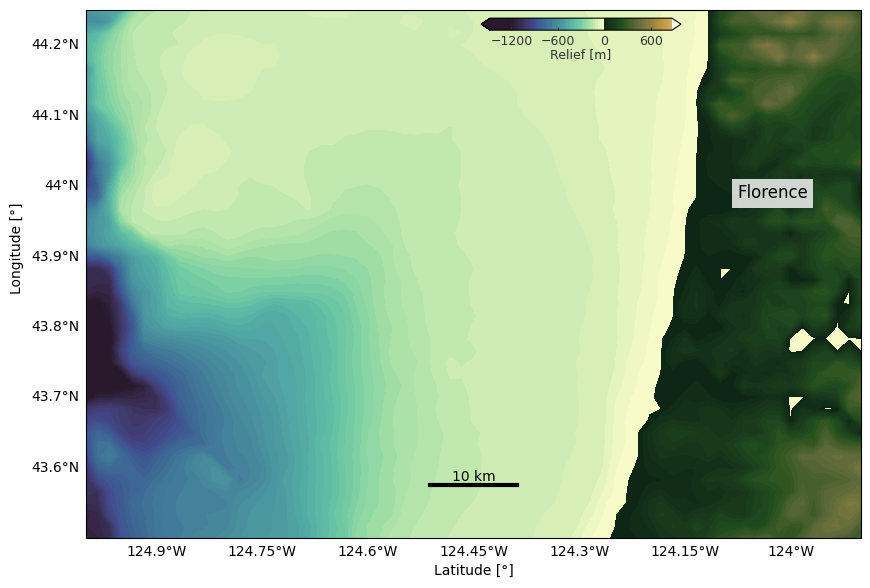

In [56]:
fig = plt.figure(figsize=(10,8),facecolor='w')
ax1 = fig.add_subplot(111, projection=ccrs.PlateCarree())
# Add Cartopy coastines.
north = 44.25
south = 43.5
west = -125.
east = -123.9
ax1.set_extent([west, east, south, north], ccrs.PlateCarree())

gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=2,
color='black',alpha=0.0, linestyle='--')
# Disable top and right grid line labels.
gl.top_labels = gl.right_labels = False
ax1.text(-0.08, 0.55, 'Longitude'u' [\N{DEGREE SIGN}]', va='bottom',
ha='center', rotation='vertical', rotation_mode='anchor',
transform=ax1.transAxes)
ax1.text(0.5, -0.075, 'Latitude'u' [\N{DEGREE SIGN}]', va='bottom',
ha='center',rotation='horizontal', rotation_mode='anchor',
transform=ax1.transAxes)

ax1.text(-124.075998, 43.9826, 'Florence',color='k',fontsize=12, bbox=dict(fill=True, \
        edgecolor='black', color='w', linewidth=0,alpha=0.8, zorder=6))


bathy_levels = [-2000]
Ct = ax1.contour(gaussian_filter(lon,2),gaussian_filter(lat,2)
,gaussian_filter(bathy,2),bathy_levels,colors='black',latlon=True,
linewidths=0.6,linestyles='solid')
manual_locations = [(-124.8,43.6),(-124.7,44),(-124.3,43.6)] 
clbls = ax1.clabel(Ct,fmt='%i', fontsize=9,manual=manual_locations, colors="black")
scale_bar(ax1,length=10)


# Add Topo
lon1 = ds.variables['lon'][:]
lat1 = ds.variables['lat'][:]
topo1 = ds.variables['Band1'][:]

plot = ax1.contourf(lon, lat, bathy, 100, cmap=cmocean.cm.topo,
transform=ccrs.PlateCarree(),latlon=True,vmin=-1200, vmax=1200,
extend="both")
          
ticks  = [-1200, -600, 0, 600 ]
cax=fig.add_axes([0.52, 0.8, 0.2, 0.015])
cb=fig.colorbar(plot, cax=cax, orientation="horizontal")

cb.set_label(r'Relief [m]', fontsize=9, color='0.2',labelpad=0)
cb.ax.tick_params(labelsize=9, length=2, color='0.2', labelcolor='0.2',direction='in')
cb.set_ticks(ticks)